Okt 2015
<img width=300 src="./fig/ladisk.png">

<center>[izr.prof. dr. Janko Slavič](http://www.ladisk.si/~slavic)</center>


<center>[Repozitorij pypinm](http://github.com/jankoslavic/pypinm)</center>

In [1]:
from sympy import *
init_printing()

# Aproksimacija

Na predhodnih predavanjih smo si pogledali interpolacijo, ki pa ni vedno ustrezen način popisa manjkajočih vrednosti. Poglejmo si primer:

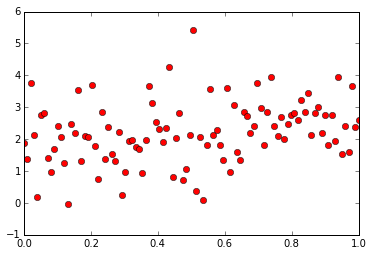

In [57]:
n = 100
k = 1.
c = 2.
x = np.linspace(0, 1, n)
y = k*x + c  + np.random.normal(scale=1, size=len(x))
plt.plot(x, y, 'ro');

Očitno je, da so rezultati zgoraj rezultat linearne funkcije, ki je popačena zaradi šuma. Interpolacija (npr s kubičnimi zlepki) bi napačno popisala dejansko ozadje procesa:

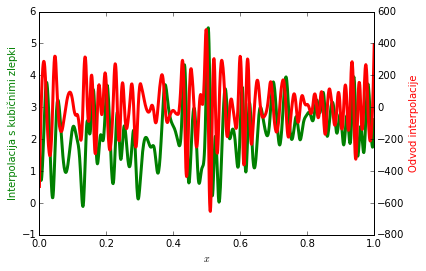

In [58]:
from scipy.interpolate import InterpolatedUnivariateSpline

spl = InterpolatedUnivariateSpline(x, y) # to ni naravni zlepek - bomo pozneje definirali!
spl1 = spl.derivative(1)
xint = np.linspace(np.min(x), np.max(x), 10*n)

fig, ax1 = plt.subplots()
ax1.plot(xint, spl(xint), 'g', lw=3)
ax1.set_xlabel('$x$')
ax1.set_ylabel('Interpolacija s kubičnimi zlepki', color='g')

ax2 = ax1.twinx()
ax2.plot(xint, spl1(xint), 'r', lw=3)
ax2.set_ylabel('Odvod interpolacije', color='r')
plt.show()

Opazimo, da je že interpolacija *napačna*, še bolj se pokaže to pri odvodu.

Za konkreten primer zgoraj bi bilo bolje, če bi dane točke poskušali popisati z linearno funkcijo:
$$f(x) = a_0\,x+ a_1$$

Seveda poznamo pare $x_i, y_i$; teh je celo veliko več kakor jih potrebujemo za določitev dveh konstant. Matematiki bi rekli, da gre za predoločen sistem linearnih enačb. Iz tega razloga moramonajti ustrezne parametre $a_i$, ki se *najbolje* ujemajo z danimi točkami. Najprej torej potrebujemo kriterij za *najboljše* ujemanje. Za vse znane pare $x_i, y_i$ bi lahko iskali takšna parametra $a_0$ in $a_1$ kjer bi bila vsota absolutne vrednosti odstopkov $S$ najmanjša:
$$S = \sum_i |y_i - (a_0\,x_i+a_1)|.$$
Podoben pogoj, ki pa ga je bistveno lažje implementirati je *najmanjše kvadratično odstopanje*:
$$S = \sum_i \left(y_i - (a_0\,x_i+a_1)\right)^2.$$

# Metoda najmanjših kvadratov za linearno funkcijo

Poiskati moramo konstante $a_0$, $a_1$, da bo napaka
$$S = \sum_i^n \left(y_i - (a_0\,x_i-a_1)\right)^2$$
najmanjša. Matemtično to pomeni, da mora biti takrat prvi odvod $S$ po konstantah $a_i$ enak nič:
$$\frac{\mathrm{d}S}{\mathrm{d}a_0} = 2\,\sum_i^n \left(y_i - a_0\,x_i-a_1\right)\,x_i=2\left(\sum_i^n y_i\,x_i -a_0\,\sum_i^n x_i^2- a_1\,\sum_i^n x_i\right)=0$$
in
$$\frac{\mathrm{d}S}{\mathrm{d}a_1} = 2\,\sum_i^n \left(y_i  - a_0\,x_i- a_1\right)=2\left(\sum_i^n y_i -a_0\,\sum_i^n x_i- a_1\,n\right)=0$$

Izraza uredimo:
$$a_0\,\sum_i^n x_i^2 + a_1\,\sum_i^n x_i=\sum_i^n y_i\,x_i$$
in
$$a_0\,\sum_i^n x_i+ a_1\,n=\sum_i^n y_i$$

Opazimo, da imamo sistem dveh enačb, ki imata dve neznanki ($a_0$ in $a_1$). Zapišemo torej matriko koeficientov:

In [65]:
A = [[np.sum(x**2), np.sum(x)],
     [np.sum(x), len(x)]]
b = [np.dot(y,x), np.sum(y)]
A = np.asarray(A)
b = np.asarray(b)
print('A:', A)
print('b:', b)

A: [[  33.5016835   50.       ]
 [  50.         100.       ]]
b: [ 118.87746307  221.67098114]


Sedaj moramo rešiti linearni sistem:
$$\mathbf{A}\,\mathbf{x}=\mathbf{b},$$
ki ga imenujemo tudi *normalni sistem enačb* in bi namesto $\mathbf{x}$ lahko pisali tudi $\mathbf{a}=(a_0, a_1)$.

Sistem rešimo:

In [66]:
a0, a1 = np.linalg.solve(A, b)
a0, a1

Preverimo še pogojenost:

In [67]:
np.linalg.cond(A)

Lahko tudi uporabimo ``numpy`` funkcijo

In [72]:
a0_np, a1_np = np.polyfit(x, y, deg=1)
a0_np, a1_np

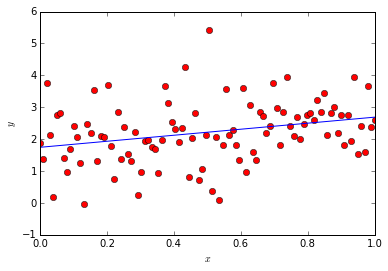

In [73]:
plt.plot(x,y, 'ro');
plt.plot(x, a0*x + a1);
plt.xlabel('$x$')
plt.ylabel('$y$');

Sedaj se spomnimo odvoda interpolacije s kubičnimi zlepki in ga primerjajmo z vrednostjo tukaj:

In [74]:
a0

# Metoda najmanjših kadratov za poljubni polinom

Poljubni polinom opišemo:
$$f(x) = \sum_{v}^{m}a_v\,\underbrace{x^{m-v}}_{f_v(x)},$$
kjer $f_v(x)$ imenujemo bazna funkcija.

Napako med aproksimtivni funkcijo in podatki opišemo z:
$$S = \sum_i \left(y_i - f(x_i)\right)^2.$$
Iščemo minimum napake, torej mora za vsak $a_v$ veljati:
$$\frac{\mathrm{d}S}{\mathrm{d}a_v} = - 2\,\sum_i^n \left(\left(y_i - f(x_i)\right)\,x_i^{m-v}\right)=0.$$

Enačbo preoblikujemo:
$$\sum_i^n f(x_i)\,x_i^{m-v}=\sum_i^n y_i\,x_i^{m-v},$$
sledi (ker obravnavamo odvajanje po $v$, tukaj v funkciji $f(x)$ zamenjamo indeks $v$ s $s$):

$$\sum_i^n \sum_s^m a_s\,x_i^{2m-s-v}=\sum_i^n y_i\,x_i^{m-v}$$
zamenjamo vrstni red seštevanja:
$$\sum_s^m \left(a_s \sum_i^n \,x_i^{2m-s-v}\right)=\sum_i^n y_i\,x_i^{m-v}.$$

Če dobro pogledamo, smo izpeljali eno enačbo sistem $m$ linearnih enačb. Element $A_{v,s}$ matrike koeficientov je definiran kot:
$$A_{v,s}= \sum_i^n x_i^{2m-v-s}$$
in vektor konstant:
$$b_{v}= \sum_i^n y_i\,x_i^{m-v}$$

Poglejmo si primer polinoma druge stopnje:

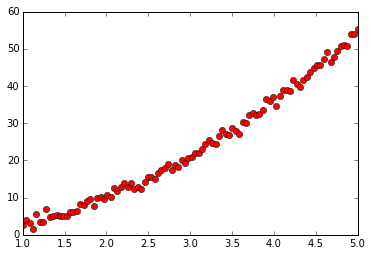

In [76]:
x = np.linspace(1, 5, 100)
y = 2.*x**2 + 1.*x + 0. + np.random.normal(size=len(x))
plt.plot(x, y, 'ro');

Izračunajmo matriko koeficientov in vektor konstant

In [90]:
m = 2 #stopnja
A = np.zeros((m+1,m+1))
for v in range(m+1):
    for s in range(m+1):
        A[v,s] = np.sum(x**(2*m-v-s))
b = np.zeros(m+1)
for v in range(m+1):
    b[v] = np.dot(y,x**(m-v))

In [78]:
A

array([[ 15778.47002488,   3924.24242424,   1036.02693603],
       [  3924.24242424,   1036.02693603,    300.        ],
       [  1036.02693603,    300.        ,    100.        ]])

In [79]:
b

array([ 35434.25061349,   8884.35806551,   2375.84581798])

Preverimo pogojenost:

In [80]:
np.linalg.cond(A)

in rešimo sistem:

In [82]:
a = np.linalg.solve(A, b)
a

array([ 1.88485034,  1.60613861, -0.58751485])

In [84]:
y_app = np.sum(np.asarray([_*x**(m-i) for i,_ in enumerate(a)]), axis=0)

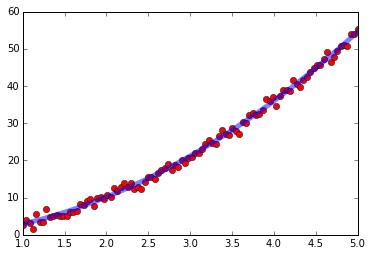

In [91]:
plt.plot(x, y, 'ro')
plt.plot(x, y_app, lw=5, alpha=0.5);

Preverimo še ``numpy`` funkcijo:

In [92]:
np.polyfit(x, y, deg=2)

array([ 1.88485034,  1.60613861, -0.58751485])

Opazimo, da je matrika koeficientov lahko hitro slaba in je posledično tudi aproksimacija slaba. Višje stopnje polinom uporabimo, večja je verjetnost slabe pogojenosti. Iz tega razloga s stopnjo polinoma nima smisla pretiravati (v praksi uporabljamo predvsem nizke stopnje)!

# Aproksimacija s poljubno funkcijo

S pomočjo ``scipy.optimize.curve_fit`` lahko uporabimo metodo najmanjših kvadratov na poljubni funkciji. Poglejmo si preprosti primer:

In [142]:
def func(t, A, w, faza):
    return A*np.sin(w*t+faza)

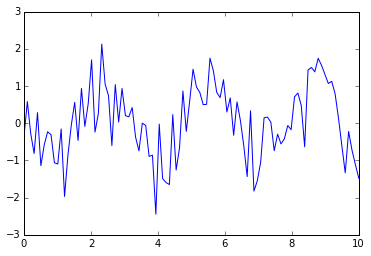

In [150]:
t = np.linspace(0, 10, 100)
y = func(t, 1, 2, 3) + np.random.normal(scale=0.6, size=len(t))
plt.plot(t, y);

Uprabimo sedaj ``curve_fit`` funkcijo:

In [151]:
from scipy.optimize import curve_fit

In [152]:
popt, pcov = curve_fit(func, t, y, p0=[1, 2.3, 1])
popt

array([ 1.02717983,  2.01437727,  2.95047865])

# Aproksimacija z zlepki in uporabo ``SciPy``

Zadnjič smo si pogledali objekt ``InterpolatedUnivariateSpline``, ki v bistvu temelji na bolj splošnem objektu ``UnivariateSpline``. Poglejmo si razliko na primeru:

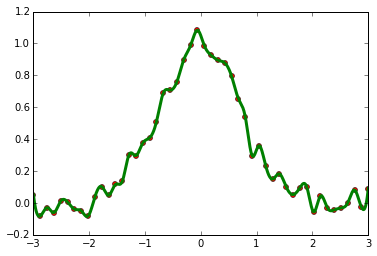

In [108]:
from scipy.interpolate import UnivariateSpline
x = np.linspace(-3, 3, 50)
y = np.exp(-x**2) + 0.1 * np.random.normal(scale=.5, size=len(x))
spl = UnivariateSpline(x, y, s=0.)
xs = np.linspace(-3, 3, 1000)
plt.plot(x, y, 'ro', ms=5)
plt.plot(xs, spl(xs), 'g', lw=3);

Opazimo, da z uporabo parametra `s=0` v bistvu izvedemo interpolacijo. Razlika med obema objektoma je torej v parametru `s`; poglejmo si help zanj:

* s : float or None, optional

    Positive smoothing factor used to choose the number of knots. Number of knots will be increased until the smoothing condition is satisfied:
        sum((w[i] * (y[i]-spl(x[i])))**2, axis=0) <= s
    If None (default), s = len(w) which should be a good value if 1/w[i] is an estimate of the standard deviation of y[i]. If 0, spline will interpolate through all data points.
    
Predpostavimo, da je utež `w[i]=1`: če uporabimo parameter `s=0`, bo torej napaka v točkah kjer imamo podatke enaka 0; edini način, da se to izvede je interpolacija skozi vse točke. Če je parameter `s` večji kot nič, potem se število vozlov povečuje dokler ni zadoščenu zgornjemu kriteriju.

In [111]:
spl.get_knots()

array([-3.        , -1.40816327,  0.06122449,  0.79591837,  1.53061224,
        2.26530612,  3.        ])

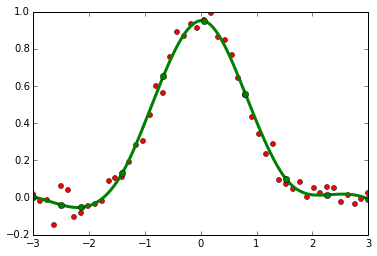

In [130]:
from scipy.interpolate import UnivariateSpline
x = np.linspace(-3, 3, 50)
y = np.exp(-x**2) + 0.1 * np.random.normal(scale=.5, size=len(x))
spl = UnivariateSpline(x, y, s=0.1)
xs = np.linspace(-3, 3, 1000)
plt.plot(x, y, 'ro', ms=5)
plt.plot(xs, spl(xs), 'g', lw=3);
plt.plot(spl.get_knots(), spl(spl.get_knots()), 'go');
spl.get_residual()

0.10009529799801341
0.6000021923424949


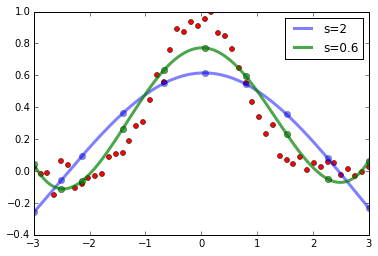

In [131]:
print(spl.get_residual())
plt.plot(x, y, 'ro', ms=5)
spl.set_smoothing_factor(s=2)
plt.plot(xs, spl(xs), 'b', lw=3, alpha=0.5, label='s=2')
plt.plot(spl.get_knots(), spl(spl.get_knots()), 'bo', alpha=0.5, lw=3);
spl.set_smoothing_factor(s=.6)
plt.plot(xs, spl(xs), 'g', lw=3, alpha=0.7, label='s=0.6')
plt.plot(spl.get_knots(), spl(spl.get_knots()), 'go', alpha=0.7, lw=3);
plt.legend()
print(spl.get_residual())

# Do naslednjih vaj preštudirajte sledeče:

1. Na podatkih:
$$x = [-1.00, -0.50, 0.00, 0.50, 1.00]$$
$$y = [−1.00, −0.55, 0.00, 0.45, 1.00]$$
uporabite linearne zlepke in določite prvi odvod.
* Na zgornjih podatkih izračunajte linearno aproksicijo ter določite parametra aproksimacije.
* Na nateznem testu ste testirali aluminijeve vzorce; rezultati testa so podani spodaj.

    Napetost [MPa]:
$$\sigma = [34.5, 69.0, 103.5, 138.0]$$

    Specifična deformacija [mm/m]
$$vzorec_1 = [0.46, 0.95, 1.48, 1.93]$$
$$vzorec_2 = [0.34, 1.02, 1.51, 2.09]$$
$$vzorec_3 = [0.37, 1.00, 1.51, 2.05]$$
    S pomočjo linearne aproksimacije določite elastični modul (napetost/specifična deformacija) vsakega posameznega vzorca.
* Za Al vzorce zgoraj linearno aproksimirajte elastični modul čez vse vzorce. Določite tudi standardno napako (glejte ``np.std``).
* Raziščite pomoč za funkcijo ``np.polyfit`` in utežite različne vzorce z različno utežjo (npr. da prvi meritvi zaupate manj). Izračunajte nato linearno aproksimiran elastični modul.
* Pojasnite bistvo metode najmanjših kvadratov na primeru linearne aproksimacije. 
* Za podatke:
$$x = [1.0, 2.5, 3.5, 4.0, 1.1, 1.8, 2.2, 3.7]$$
$$y = [6.008, 15.722, 27.130, 33.772, 5.257, 9.549, 11.098, 28.828$$
    Pripravite in pojasnite funkcijo za linearno aproksimacijo.
* Nadaljujte zgornjo nalogo in z vgrajeno funkcijo ``np.polyfit`` izvedite linearno, kvadratno in kubično polinomsko aproksimacijo. 
* Nadaljujte zgornjo nalogo in aproksimacije narišite ter določite standarno napako. Katera aproksimacija najbolje popište podatke?
* Definirajte polinom 2 ali 3 stopnje. Dodajte šum (enakomeren ``np.random.rand`` ali normalen ``np.random.randn``) ter nato aproksimirajte s polinomom 1, 2 in 3 stopnje. Vse rezultate narišite in vrednotite rezultat.

Delno rešene vaje se nahajajo [tukaj](./vaje/Vaja 8 - polovica.ipynb).

## Ekstra

Naredite *exe* svojega programa:
https://pypi.python.org/pypi/py2exe/0.9.2.2